<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=300 height=300 align=left class="saturate" >

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2024<br>
<div dir=ltr align=center>

<font color=3C99D size=5>
    Practical Assignment 5 - Reinforcement Learning <br>
<font color=696880 size=4>
    Kiarash Joolaei


# Personal Data

In [ ]:
student_number = '401106396'
name = 'Mobina kochaknia'

Our goal in this notebook is to train an agent on game environments such as `FrozenLake-v1` and `Taxi-v3` using reinforcement learning algorithms. The mentioned environments are selected from the `gym` library.

# Introduction to Gym Library

The **Gym** library, developed by OpenAI, is a toolkit for building and evaluating reinforcement learning (RL) algorithms. It provides a variety of predefined environments ranging from simple tasks, like balancing a pole, to complex ones, like playing video games or robotic simulations. Gym's standardized API ensures compatibility with most RL algorithms.

## How Gym Environments Work

### 1. Environment Setup
Each environment represents a specific RL task and is initialized using `gym.make()`.

### 2. Interaction with the Environment
- **Reset the Environment**:
  Use `reset()` to initialize the environment and get the starting state.

- **Take Actions**:
  Use `step(action)` to interact with the environment. This method returns:
  - **Next State**: The resulting state after the action.
  - **Reward**: A scalar feedback signal for the action.
  - **Done**: A boolean indicating if the episode is over.
  - **Info**: Additional diagnostic information.

### 3. Rendering the Environment
Environments can be visualized using `render()` to display the task.

### 4. Closing the Environment
After use, call `close()` to clean up resources.



# Libraries

Import the neccesary libraries here.

In [ ]:
import numpy as np
import random
import gym
import time
from IPython.display import clear_output, HTML
import matplotlib.pyplot as plt
from base64 import b64encode
import imageio


The `record_video` and `show_video` functions can visualize the outcome of a sampled trajectory. They will be useful later.

In [ ]:
def record_video(env, Qtable, out_directory, fps=1, random_action=False, max_steps=100):
    """
    Record a video of the agent playing the game according to the learned policy.

    Parameters:
    - env: The OpenAI Gym environment.
    - Qtable: The Q-table learned by the agent.
    - out_directory: The file path to save the video.
    - fps: Frames per second in the video.
    - random_action: Whether the agent should take random actions or follow the learned policy.
    - max_steps: Maximum number of steps per episode.

    Returns:
    - total_reward: The total reward earned during the episode.
    """
    images = []
    done = False

    # Handle different gym versions for reset() function
    reset_output = env.reset()
    state = reset_output[0] if isinstance(reset_output, tuple) else reset_output
    info = reset_output[1] if isinstance(reset_output, tuple) else {}

    img = env.render(mode='rgb_array')
    images.append(img)
    total_reward = 0
    i = 0
    while not done:
        i += 1
        if i > max_steps:
            break
        action = np.random.randint(4) if random_action else np.argmax(Qtable[state])
        # Unpack step depending on whether 'truncated' is present
        step_output = env.step(action)
        if len(step_output) == 4:
            state, reward, done, info = step_output  # No truncated field
        else:
            state, reward, done, truncated, info = step_output  # Includes truncated field

        total_reward += reward
        img = env.render(mode='rgb_array')
        images.append(img)
        if not random_action:
            print(f"action: {action}, state: {state}, reward: {reward}, done: {done}, info: {info}")

    # Save the video as an .mp4 file
    video_path = out_directory + "/gameplay.mp4"
    imageio.mimsave(video_path, [np.array(img) for img in images], fps=fps)

    return total_reward, video_path


def show_video(video_path, video_width=300):
    """
    Display the recorded video within a Jupyter notebook.

    Parameters:
    - video_path: The file path to the video.
    - video_width: The width of the video displayed in the notebook.
    """
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Environment

### FrozenLake environment
The `FrozenLake-v1` environment is a variant of the classic reinforcement learning problem where the agent must navigate a grid while avoiding obstacles.


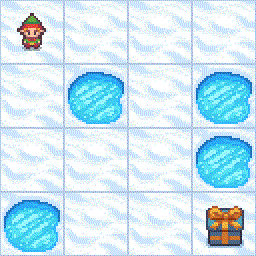


In [ ]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True)
spec = gym.spec('FrozenLake-v1')


print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Range: {env.reward_range}")
print(f"Reward Threshold: {spec.reward_threshold}\n")

state_space = env.observation_space.n
action_space = env.action_space.n

Action Space: Discrete(4)
Observation Space: Discrete(16)
Max Episode Steps: 100
Nondeterministic: False
Reward Range: (0, 1)
Reward Threshold: 0.7



# Agent

In this section, you should implement the base class `Agent`. All future types of agents will inherit this class.

In [ ]:
class Agent:
    def __init__(self, state_space, action_space, learning_rate=0.1, min_lr=0.001, max_lr=0.1, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        """
        Base class for an RL agent.

        Parameters:
        - state_space: int, number of states in the environment.
        - action_space: int, number of actions in the environment.
        - learning_rate: float, initial learning rate for Q-value updates.
        - min_lr: float, minimum value of the learning rate.
        - max_lr: float, maximum value of the learning rate.
        - discount_factor: float, discount factor for future rewards.
        - epsilon: float, initial exploration rate.
        - epsilon_decay: float, rate at which epsilon decays after each episode.
        - epsilon_min: float, minimum value of epsilon.
        """
        self.state_space = state_space
        self.action_space = action_space
        self.learning_rate = learning_rate
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros((state_space, action_space))

    def choose_action(self, state):
        """
        Choose an action based on the epsilon-greedy policy.

        Parameters:
        - state: int, current state.

        Returns:
        - action: int, chosen action.
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_space)
        else:
            return np.argmax(self.q_table[state])

    def get_q_value(self, state, action):
        """
        Get the Q-value for the given state-action pair.
        """
        return self.q_table[state, action]

    def decay_epsilon(self):
        """
        Decay the exploration rate (epsilon).
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def decay_lr(self, decay_rate):
        """
        Decay the learning rate within min and max bounds.

        Parameters
        - decay_rate: float, the factor by which to decay the learning rate.
        """
        self.learning_rate = max(self.min_lr, self.learning_rate * decay_rate)

# Q Learning


**Q-learning** is a model-free reinforcement learning algorithm used to find an optimal policy for an agent interacting with an environment. It uses a Q-table to store the estimated quality (Q-values) of taking specific actions in particular states. The algorithm updates the Q-values iteratively using the Bellman equation:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha \big[ r + \gamma \max_a Q(s', a) - Q(s, a) \big]
$$

where $s$ and $a$ are the current state and action, $s'$ is the next state, $r$ is the reward, $\alpha$ is the learning rate, and $\gamma$ is the discount factor. The agent balances exploration (trying new actions) and exploitation (choosing actions with high Q-values) using strategies like the epsilon-greedy policy. Over time, Q-learning converges to the optimal Q-values, allowing the agent to act optimally in the environment.
Here you should implement the `QLearningAgent` class inherited from `Agent`.


In [ ]:
class QLearningAgent(Agent):
    def __init__(self, state_space, action_space, learning_rate=0.1, min_lr=0.001, max_lr=0.1, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        """
        Q-learning agent that extends the base Agent class.
        """
        super().__init__(state_space, action_space, learning_rate, min_lr, max_lr, discount_factor, epsilon, epsilon_decay, epsilon_min)

    def update(self, state, action, reward, next_state, done):
        """
        Update the Q-value using the Q-learning update rule.

        Parameters:
        - state: int, current state.
        - action: int, action taken.
        - reward: float, reward received.
        - next_state: int, next state.
        - done: bool, whether the episode has terminated.
        """
        if done:
            target = reward
        else:
            target = reward + self.discount_factor * np.max(self.q_table[next_state])

        self.q_table[state, action] += self.learning_rate * (target - self.q_table[state, action])

# SARSA


**SARSA** (State-Action-Reward-State-Action) is an on-policy reinforcement learning algorithm that learns an optimal policy by updating Q-values based on the agent's experience. Unlike Q-learning, which considers the maximum possible reward from the next state, SARSA updates Q-values using the actual action chosen by the current policy. The update rule is given by:

$$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \left( R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t) \right)$$


Where $Q(S_t,A_t)$ is the current estimate of the expected return for taking action $A_t$ in state $S_t$, $\alpha$ is the learning rate, $R_{t+1}$ is the reward received after taking action $A_t$ in state $S_t$, $\gamma$ is the discount factor, and $Q(S_{t+1},A_{t+1})$ is the estimated return for taking action $A_{t+1}$ in the next state $S_{t+1}$. factor. The on-policy nature of SARSA ensures that the updates are consistent with the policy being followed, making it more sensitive to the exploration strategy. Implement the `SARSAAgent` class in a similar manner.


In [ ]:
class SARSAAgent(Agent):
    def __init__(self, state_space, action_space, learning_rate=0.1, min_lr=0.001, max_lr=0.1, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        """
        SARSA agent that extends the base Agent class.
        """
        super().__init__(state_space, action_space, learning_rate, min_lr, max_lr, discount_factor, epsilon, epsilon_decay, epsilon_min)

    def update(self, state, action, reward, next_state, next_action, done):
        """
        Update the Q-value using the SARSA update rule.

        Parameters:
        - state: int, current state.
        - action: int, action taken.
        - reward: float, reward received.
        - next_state: int, next state.
        - next_action: int, next action.
        - done: bool, whether the episode has terminated.
        """
        if done:
            target = reward
        else:
            target = reward + self.discount_factor * self.q_table[next_state, next_action]

        self.q_table[state, action] += self.learning_rate * (target - self.q_table[state, action])

# First Visit Monte Carlo

In this section we're going to do something different. Until now the described algorithms were all of the **Temporal Difference** type. This time we introduce an algorithm called **First Visit Monte Carlo** which relies on long trajectories (episodes) instead of state-action-reward tuples. It works by averaging the returns (cumulative rewards) of the first occurrence of each state in multiple episodes. Unlike dynamic programming, it does not require knowledge of the environment's transition probabilities or rewards. The algorithm proceeds as follows:

1. **Generate Episodes:** Simulate complete episodes of the agent interacting with the environment following a specific policy.
2. **Record Returns:** For each state or state-action pair, calculate the total return $G_t = \sum_{k=0}^{T-t-1} \gamma^k r_{t+k+1}$, where $r_{t+k+1}$ is the reward at time $t+k+1$, and $\gamma$ is the discount factor.
3. **Update Values:** For every state (or state-action pair), update its value by averaging the returns from all episodes where it was first visited.

Implement the class for the agent that uses this algorithm. Note that here we need the environment as an input as well.

In [ ]:
class MonteCarloAgent(Agent):
    def __init__(self, env, state_space, action_space, learning_rate=0.1, min_lr=0.001, max_lr=0.1, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        """
        Monte Carlo agent that extends the base Agent class using the First-Visit Monte Carlo method.

        Parameters:
        - env: The OpenAI Gym environment.
        - state_space: int, number of states in the environment.
        - action_space: int, number of actions in the environment.
        - learning_rate: float, initial learning rate for Q-value updates.
        - min_lr: float, minimum value of the learning rate.
        - max_lr: float, maximum value of the learning rate.
        - discount_factor: float, discount factor for future rewards.
        - epsilon: float, initial exploration rate.
        - epsilon_decay: float, rate at which epsilon decays after each episode.
        - epsilon_min: float, minimum value of epsilon.
        """
        super().__init__(state_space, action_space, learning_rate, min_lr, max_lr, discount_factor, epsilon, epsilon_decay, epsilon_min)
        self.env = env
        self.returns = {}

    def generate_episode(self):
        """
        Generate an episode (state, action, reward) tuple and return it.

        Returns:
        - episode: list of tuples (state, action, reward), representing the episode's state-action-reward triplets.
        """
        episode = []
        state = self.env.reset()
        done = False

        while not done:
            action = self.choose_action(state)
            next_state, reward, done, _ = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state

        return episode

    def update(self, episode):
        """
        Update the Q-values using the First-Visit Monte Carlo method.

        Parameters:
        - episode: list of tuples (state, action, reward), representing the episode's state-action-reward triplets.
        """
        G = 0
        visited_states = set()

        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.discount_factor * G + reward

            if (state, action) not in visited_states:
                visited_states.add((state, action))

                if (state, action) not in self.returns:
                    self.returns[(state, action)] = []

                self.returns[(state, action)].append(G)
                self.q_table[state, action] = np.mean(self.returns[(state, action)])

        self.decay_epsilon()

# Training

Implement the `Trainer` class. You can use `isinstance` to check for the type of agent when implementing the training algorithm for them.

In [ ]:
class Trainer:
    def __init__(self, agent, env, episodes=1000, max_steps_per_episode=100, lr_decay_rate=0.99):
        """
        Trainer class to handle the training of an RL agent.

        Parameters:
        - agent: instance of an RL agent (e.g., QLearningAgent, SARSAAgent, MonteCarloAgent).
        - env: OpenAI Gym environment.
        - episodes: int, number of episodes to train the agent.
        - max_steps_per_episode: int, maximum steps per episode.
        - lr_decay_rate: float, the rate at which to decay the learning rate.
        """
        self.agent = agent
        self.env = env
        self.episodes = episodes
        self.max_steps_per_episode = max_steps_per_episode
        self.lr_decay_rate = lr_decay_rate
        self.rewards_per_episode = []

    def train(self):
        """
        Train the agent over the specified number of episodes.
        """
        for episode in range(self.episodes):
            state = self.env.reset()
            total_rewards = 0
            done = False
            episode_data = []

            if isinstance(self.agent, (QLearningAgent, SARSAAgent)):
                action = self.agent.choose_action(state)

            if isinstance(self.agent, MonteCarloAgent):
                episode_data = self.agent.generate_episode()
                total_rewards = sum([reward for (_, _, reward) in episode_data])
                self.agent.update(episode_data)
            else:
                for step in range(self.max_steps_per_episode):
                    next_state, reward, done, _ = self.env.step(action)
                    total_rewards += reward
                    episode_data.append((state, action, reward))
                    if isinstance(self.agent, SARSAAgent):
                        next_action = self.agent.choose_action(next_state)
                        self.agent.update(state, action, reward, next_state, next_action, done)
                        action = next_action
                    elif isinstance(self.agent, QLearningAgent):
                        self.agent.update(state, action, reward, next_state, done)
                        action = self.agent.choose_action(next_state)
                    state = next_state

                    if done:
                        break

            self.agent.decay_epsilon()
            self.agent.decay_lr(self.lr_decay_rate)
            self.rewards_per_episode.append(total_rewards)

            if (episode + 1) % 100 == 0:
                print(f"Episode {episode + 1}/{self.episodes}: Total Reward: {total_rewards}, Epsilon: {self.agent.epsilon:.4f}")
                print(f"Episode {episode + 1}/{self.episodes}: Total Reward: {total_rewards}, Epsilon: {self.agent.epsilon:.4f}, Learning Rate: {self.agent.learning_rate:.4f}")

    def evaluate(self, episodes=100):
        """
        Evaluate the agent's performance over a number of episodes.

        Parameters:
        - episodes: int, number of episodes to evaluate the agent.

        Returns:
        - average_reward: float, average reward over the evaluation episodes.
        """
        total_rewards = 0
        for episode in range(episodes):
            state = self.env.reset()
            done = False
            episode_reward = 0

            for step in range(self.max_steps_per_episode):
                action = self.agent.choose_action(state)
                next_state, reward, done, _ = self.env.step(action)
                episode_reward += reward
                state = next_state

                if done:
                    break

            total_rewards += episode_reward

        average_reward = total_rewards / episodes
        print(f"Evaluation over {episodes} episodes: Average Reward: {average_reward}")
        return average_reward

Set the training hyperparameters for each agent. You may need to do some trial and error to find the suitable parameters.

In [ ]:
learning_rate = 0.8
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.9999
epsilon_min = 0.01
episodes = 100000
max_steps_per_episode = 100
lr_decay_rate = 0.9999
max_lr = 0.01
min_lr = 0.001

agent = QLearningAgent(
    state_space=env.observation_space.n,
    action_space=env.action_space.n,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    max_lr=max_lr,
    min_lr=min_lr,
)

trainer = Trainer(agent=agent, env=env, episodes=episodes, max_steps_per_episode=max_steps_per_episode, lr_decay_rate=lr_decay_rate)

print("Training the agent...")
trainer.train()

Training the agent...
Episode 100/100000: Total Reward: 0.0, Epsilon: 0.9900
Episode 100/100000: Total Reward: 0.0, Epsilon: 0.9900, Learning Rate: 0.7920
Episode 200/100000: Total Reward: 0.0, Epsilon: 0.9802
Episode 200/100000: Total Reward: 0.0, Epsilon: 0.9802, Learning Rate: 0.7842
Episode 300/100000: Total Reward: 0.0, Epsilon: 0.9704
Episode 300/100000: Total Reward: 0.0, Epsilon: 0.9704, Learning Rate: 0.7764
Episode 400/100000: Total Reward: 0.0, Epsilon: 0.9608
Episode 400/100000: Total Reward: 0.0, Epsilon: 0.9608, Learning Rate: 0.7686
Episode 500/100000: Total Reward: 0.0, Epsilon: 0.9512
Episode 500/100000: Total Reward: 0.0, Epsilon: 0.9512, Learning Rate: 0.7610
Episode 600/100000: Total Reward: 0.0, Epsilon: 0.9418
Episode 600/100000: Total Reward: 0.0, Epsilon: 0.9418, Learning Rate: 0.7534
Episode 700/100000: Total Reward: 0.0, Epsilon: 0.9324
Episode 700/100000: Total Reward: 0.0, Epsilon: 0.9324, Learning Rate: 0.7459
Episode 800/100000: Total Reward: 0.0, Epsilon:

In [ ]:
print("Evaluating the agent...")
trainer.evaluate(episodes=100)

Qtable = agent.q_table
total_reward, video_path = record_video(env, Qtable, out_directory=".", fps=2, random_action=False, max_steps=100)
show_video(video_path)

Evaluating the agent...
Evaluation over 100 episodes: Average Reward: 0.73
action: 0, state: 4, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 8, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 3, state: 4, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 8, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 3, state: 9, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 1, state: 10, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 14, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 1, state: 15, reward: 1.0, done: True, info: {'prob': 0.3333333333333333, 'TimeLimit.truncated': False}


In [ ]:
learning_rate = 0.1
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.9999
epsilon_min = 0.01
episodes = 100000
max_steps_per_episode = 100
lr_decay_rate = 0.9999
max_lr = 0.1
min_lr = 0.01

agent = SARSAAgent(
    state_space=env.observation_space.n,
    action_space=env.action_space.n,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    max_lr=max_lr,
    min_lr=min_lr,
)

trainer = Trainer(agent=agent, env=env, episodes=episodes, max_steps_per_episode=max_steps_per_episode, lr_decay_rate=lr_decay_rate)

print("Training the agent...")
trainer.train()

Training the agent...
Episode 100/100000: Total Reward: 0.0, Epsilon: 0.9900
Episode 100/100000: Total Reward: 0.0, Epsilon: 0.9900, Learning Rate: 0.0990
Episode 200/100000: Total Reward: 0.0, Epsilon: 0.9802
Episode 200/100000: Total Reward: 0.0, Epsilon: 0.9802, Learning Rate: 0.0980
Episode 300/100000: Total Reward: 0.0, Epsilon: 0.9704
Episode 300/100000: Total Reward: 0.0, Epsilon: 0.9704, Learning Rate: 0.0970
Episode 400/100000: Total Reward: 0.0, Epsilon: 0.9608
Episode 400/100000: Total Reward: 0.0, Epsilon: 0.9608, Learning Rate: 0.0961
Episode 500/100000: Total Reward: 0.0, Epsilon: 0.9512
Episode 500/100000: Total Reward: 0.0, Epsilon: 0.9512, Learning Rate: 0.0951
Episode 600/100000: Total Reward: 0.0, Epsilon: 0.9418
Episode 600/100000: Total Reward: 0.0, Epsilon: 0.9418, Learning Rate: 0.0942
Episode 700/100000: Total Reward: 0.0, Epsilon: 0.9324
Episode 700/100000: Total Reward: 0.0, Epsilon: 0.9324, Learning Rate: 0.0932
Episode 800/100000: Total Reward: 0.0, Epsilon:

In [ ]:
print("Evaluating the agent...")
trainer.evaluate(episodes=100)

Qtable = agent.q_table
total_reward, video_path = record_video(env, Qtable, out_directory=".", fps=2, random_action=False, max_steps=100)
show_video(video_path)

Evaluating the agent...
Evaluation over 100 episodes: Average Reward: 0.77
action: 0, state: 4, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 4, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 0, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 4, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 8, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 3, state: 9, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 1, state: 8, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 3, state: 8, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 3, state: 9, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 1, state: 8, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 3, state: 4, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 8, re

In [ ]:
learning_rate = 0.1
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.9999
epsilon_min = 0.01
episodes = 100000
max_steps_per_episode = 100
lr_decay_rate = 0.9999
max_lr = 0.1
min_lr = 0.01

agent = MonteCarloAgent(
    state_space=env.observation_space.n,
    action_space=env.action_space.n,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    max_lr=max_lr,
    min_lr=min_lr,
    env=env
)

trainer = Trainer(agent=agent, env=env, episodes=episodes, max_steps_per_episode=max_steps_per_episode, lr_decay_rate=lr_decay_rate)

print("Training the agent...")
trainer.train()

Training the agent...
Episode 100/100000: Total Reward: 0.0, Epsilon: 0.9802
Episode 100/100000: Total Reward: 0.0, Epsilon: 0.9802, Learning Rate: 0.0990
Episode 200/100000: Total Reward: 0.0, Epsilon: 0.9608
Episode 200/100000: Total Reward: 0.0, Epsilon: 0.9608, Learning Rate: 0.0980
Episode 300/100000: Total Reward: 0.0, Epsilon: 0.9418
Episode 300/100000: Total Reward: 0.0, Epsilon: 0.9418, Learning Rate: 0.0970
Episode 400/100000: Total Reward: 0.0, Epsilon: 0.9231
Episode 400/100000: Total Reward: 0.0, Epsilon: 0.9231, Learning Rate: 0.0961
Episode 500/100000: Total Reward: 0.0, Epsilon: 0.9048
Episode 500/100000: Total Reward: 0.0, Epsilon: 0.9048, Learning Rate: 0.0951
Episode 600/100000: Total Reward: 0.0, Epsilon: 0.8869
Episode 600/100000: Total Reward: 0.0, Epsilon: 0.8869, Learning Rate: 0.0942
Episode 700/100000: Total Reward: 0.0, Epsilon: 0.8694
Episode 700/100000: Total Reward: 0.0, Epsilon: 0.8694, Learning Rate: 0.0932
Episode 800/100000: Total Reward: 0.0, Epsilon:

In [ ]:
print("Evaluating the agent...")
trainer.evaluate(episodes=100)

Qtable = agent.q_table
total_reward, video_path = record_video(env, Qtable, out_directory=".", fps=2, random_action=False, max_steps=100)
show_video(video_path)

Evaluating the agent...
Evaluation over 100 episodes: Average Reward: 0.68
action: 0, state: 0, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 0, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 0, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 0, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 0, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 0, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 0, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 4, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 0, state: 8, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 3, state: 9, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 1, state: 8, reward: 0.0, done: False, info: {'prob': 0.3333333333333333}
action: 3, state: 8, re

# Which One Wins?!

Now that all the algorithms are implemented, we're going to test them on some other possibly trickier environments. These algorithms may function differently on these environments. Explain which of these algorithms are better for each one of the environments and why. Lastly plot the rewards for `Taxi-v3` environment.

In [ ]:
class CustomFrozenLakeEnv(gym.Wrapper):
    def __init__(self, env, hole_reward=-1.0, goal_reward=1.0, step_penalty=0.0):
        super().__init__(env)
        self.hole_reward = hole_reward
        self.goal_reward = goal_reward
        self.step_penalty = step_penalty

    def step(self, action):

        state, reward, done, info = self.env.step(action)

        if done:
            if reward == 1:
                reward = self.goal_reward
            else:
                reward = self.hole_reward
        else:
            reward = self.step_penalty

        return state, reward, done, info

original_env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=False)
env = CustomFrozenLakeEnv(original_env, hole_reward=-1.0, goal_reward=10.0, step_penalty=0.0)

state_space = env.observation_space.n
action_space = env.action_space.n

In [ ]:
########_____QLearning_____########
learning_rate = 0.1
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.9999
epsilon_min = 0.01
episodes = 100000
max_steps_per_episode = 100
lr_decay_rate = 0.9999
max_lr = 0.1
min_lr = 0.01

agent = QLearningAgent(
    state_space=state_space,
    action_space=action_space,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    max_lr=max_lr,
    min_lr=min_lr,
)

trainer = Trainer(agent=agent, env=env, episodes=episodes, max_steps_per_episode=max_steps_per_episode, lr_decay_rate=lr_decay_rate)

print("Training the agent...")
trainer.train()

Training the agent...
Episode 100/100000: Total Reward: -1.0, Epsilon: 0.9900
Episode 100/100000: Total Reward: -1.0, Epsilon: 0.9900, Learning Rate: 0.0990
Episode 200/100000: Total Reward: -1.0, Epsilon: 0.9802
Episode 200/100000: Total Reward: -1.0, Epsilon: 0.9802, Learning Rate: 0.0980


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 300/100000: Total Reward: -1.0, Epsilon: 0.9704
Episode 300/100000: Total Reward: -1.0, Epsilon: 0.9704, Learning Rate: 0.0970
Episode 400/100000: Total Reward: -1.0, Epsilon: 0.9608
Episode 400/100000: Total Reward: -1.0, Epsilon: 0.9608, Learning Rate: 0.0961
Episode 500/100000: Total Reward: -1.0, Epsilon: 0.9512
Episode 500/100000: Total Reward: -1.0, Epsilon: 0.9512, Learning Rate: 0.0951
Episode 600/100000: Total Reward: -1.0, Epsilon: 0.9418
Episode 600/100000: Total Reward: -1.0, Epsilon: 0.9418, Learning Rate: 0.0942
Episode 700/100000: Total Reward: -1.0, Epsilon: 0.9324
Episode 700/100000: Total Reward: -1.0, Epsilon: 0.9324, Learning Rate: 0.0932
Episode 800/100000: Total Reward: -1.0, Epsilon: 0.9231
Episode 800/100000: Total Reward: -1.0, Epsilon: 0.9231, Learning Rate: 0.0923
Episode 900/100000: Total Reward: -1.0, Epsilon: 0.9139
Episode 900/100000: Total Reward: -1.0, Epsilon: 0.9139, Learning Rate: 0.0914
Episode 1000/100000: Total Reward: -1.0, Epsilon: 0.904

In [ ]:
print("Evaluating the agent...")
trainer.evaluate(episodes=100)

Qtable = agent.q_table
total_reward, video_path = record_video(env, Qtable, out_directory=".", fps=2, random_action=False, max_steps=100)
show_video(video_path)

Evaluating the agent...
Evaluation over 100 episodes: Average Reward: 9.78
action: 2, state: 1, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 2, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 3, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 4, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 12, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 20, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 21, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 22, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 30, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 31, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 39, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 47, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 55, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 63, reward: 10.0, done: Tru

In [ ]:
########_____SARSA_____########

learning_rate = 0.1
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.9999
epsilon_min = 0.01
episodes = 100000
max_steps_per_episode = 100
lr_decay_rate = 0.9999
max_lr = 0.1
min_lr = 0.01

agent = SARSAAgent(
    state_space=state_space,
    action_space=action_space,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    max_lr=max_lr,
    min_lr=min_lr,
)
trainer = Trainer(agent=agent, env=env, episodes=episodes, max_steps_per_episode=max_steps_per_episode, lr_decay_rate=lr_decay_rate)

print("Training the agent...")
trainer.train()

Training the agent...
Episode 100/100000: Total Reward: -1.0, Epsilon: 0.9900
Episode 100/100000: Total Reward: -1.0, Epsilon: 0.9900, Learning Rate: 0.0990
Episode 200/100000: Total Reward: -1.0, Epsilon: 0.9802
Episode 200/100000: Total Reward: -1.0, Epsilon: 0.9802, Learning Rate: 0.0980
Episode 300/100000: Total Reward: -1.0, Epsilon: 0.9704
Episode 300/100000: Total Reward: -1.0, Epsilon: 0.9704, Learning Rate: 0.0970
Episode 400/100000: Total Reward: -1.0, Epsilon: 0.9608
Episode 400/100000: Total Reward: -1.0, Epsilon: 0.9608, Learning Rate: 0.0961
Episode 500/100000: Total Reward: -1.0, Epsilon: 0.9512
Episode 500/100000: Total Reward: -1.0, Epsilon: 0.9512, Learning Rate: 0.0951
Episode 600/100000: Total Reward: -1.0, Epsilon: 0.9418
Episode 600/100000: Total Reward: -1.0, Epsilon: 0.9418, Learning Rate: 0.0942
Episode 700/100000: Total Reward: -1.0, Epsilon: 0.9324
Episode 700/100000: Total Reward: -1.0, Epsilon: 0.9324, Learning Rate: 0.0932
Episode 800/100000: Total Reward:

In [ ]:
print("Evaluating the agent...")
trainer.evaluate(episodes=100)

Qtable = agent.q_table
total_reward, video_path = record_video(env, Qtable, out_directory=".", fps=2, random_action=False, max_steps=100)
show_video(video_path)

Evaluating the agent...
Evaluation over 100 episodes: Average Reward: 9.89
action: 2, state: 1, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 2, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 3, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 4, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 5, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 6, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 14, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 15, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 23, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 31, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 39, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 47, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 55, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 63, reward: 10.0, done: True,

In [ ]:
########_____MonteCarlo_____########

learning_rate = 0.1
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.9999
epsilon_min = 0.01
episodes = 100000
max_steps_per_episode = 100
lr_decay_rate = 0.9999
max_lr = 0.1
min_lr = 0.01

agent = MonteCarloAgent(
    state_space=state_space,
    action_space=action_space,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    max_lr=max_lr,
    min_lr=min_lr,
    env=env
)
trainer = Trainer(agent=agent, env=env, episodes=episodes, max_steps_per_episode=max_steps_per_episode, lr_decay_rate=lr_decay_rate)

print("Training the agent...")
trainer.train()

Training the agent...
Episode 100/100000: Total Reward: -1.0, Epsilon: 0.9802
Episode 100/100000: Total Reward: -1.0, Epsilon: 0.9802, Learning Rate: 0.0990


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 200/100000: Total Reward: -1.0, Epsilon: 0.9608
Episode 200/100000: Total Reward: -1.0, Epsilon: 0.9608, Learning Rate: 0.0980
Episode 300/100000: Total Reward: -1.0, Epsilon: 0.9418
Episode 300/100000: Total Reward: -1.0, Epsilon: 0.9418, Learning Rate: 0.0970
Episode 400/100000: Total Reward: -1.0, Epsilon: 0.9231
Episode 400/100000: Total Reward: -1.0, Epsilon: 0.9231, Learning Rate: 0.0961
Episode 500/100000: Total Reward: -1.0, Epsilon: 0.9048
Episode 500/100000: Total Reward: -1.0, Epsilon: 0.9048, Learning Rate: 0.0951
Episode 600/100000: Total Reward: -1.0, Epsilon: 0.8869
Episode 600/100000: Total Reward: -1.0, Epsilon: 0.8869, Learning Rate: 0.0942
Episode 700/100000: Total Reward: -1.0, Epsilon: 0.8694
Episode 700/100000: Total Reward: -1.0, Epsilon: 0.8694, Learning Rate: 0.0932
Episode 800/100000: Total Reward: -1.0, Epsilon: 0.8521
Episode 800/100000: Total Reward: -1.0, Epsilon: 0.8521, Learning Rate: 0.0923
Episode 900/100000: Total Reward: -1.0, Epsilon: 0.8353

In [ ]:
print("Evaluating the agent...")
trainer.evaluate(episodes=100)

Qtable = agent.q_table
total_reward, video_path = record_video(env, Qtable, out_directory=".", fps=2, random_action=False, max_steps=100)
show_video(video_path)

Evaluating the agent...
Evaluation over 100 episodes: Average Reward: 10.0
action: 2, state: 1, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 2, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 3, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 4, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 5, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 6, reward: 0.0, done: False, info: {'prob': 1.0}
action: 2, state: 7, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 15, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 23, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 31, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 39, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 47, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 55, reward: 0.0, done: False, info: {'prob': 1.0}
action: 1, state: 63, reward: 10.0, done: True, 

In [ ]:
env = gym.make("Taxi-v3")
spec = gym.spec('Taxi-v3')


print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Range: {env.reward_range}")
print(f"Reward Threshold: {spec.reward_threshold}\n")

state_space = env.observation_space.n
action_space = env.action_space.n

qlearning_rewards = []
sarsa_rewards = []

Action Space: Discrete(6)
Observation Space: Discrete(500)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 8



In [ ]:
########_____QLearning_____########
learning_rate = 0.1
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.9999
epsilon_min = 0.01
episodes = 100000
max_steps_per_episode = 100
lr_decay_rate = 0.9999
max_lr = 0.1
min_lr = 0.01

agent = QLearningAgent(
    state_space=state_space,
    action_space=action_space,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    max_lr=max_lr,
    min_lr=min_lr,
)

trainer = Trainer(agent=agent, env=env, episodes=episodes, max_steps_per_episode=max_steps_per_episode, lr_decay_rate=lr_decay_rate)

print("Training the agent...")
trainer.train()

qlearning_rewards = trainer.rewards_per_episode

Training the agent...


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100/100000: Total Reward: -370, Epsilon: 0.9900
Episode 100/100000: Total Reward: -370, Epsilon: 0.9900, Learning Rate: 0.0990
Episode 200/100000: Total Reward: -388, Epsilon: 0.9802
Episode 200/100000: Total Reward: -388, Epsilon: 0.9802, Learning Rate: 0.0980
Episode 300/100000: Total Reward: -325, Epsilon: 0.9704
Episode 300/100000: Total Reward: -325, Epsilon: 0.9704, Learning Rate: 0.0970
Episode 400/100000: Total Reward: -379, Epsilon: 0.9608
Episode 400/100000: Total Reward: -379, Epsilon: 0.9608, Learning Rate: 0.0961
Episode 500/100000: Total Reward: -406, Epsilon: 0.9512
Episode 500/100000: Total Reward: -406, Epsilon: 0.9512, Learning Rate: 0.0951
Episode 600/100000: Total Reward: -280, Epsilon: 0.9418
Episode 600/100000: Total Reward: -280, Epsilon: 0.9418, Learning Rate: 0.0942
Episode 700/100000: Total Reward: -343, Epsilon: 0.9324
Episode 700/100000: Total Reward: -343, Epsilon: 0.9324, Learning Rate: 0.0932
Episode 800/100000: Total Reward: -298, Epsilon: 0.9231

In [ ]:
print("Evaluating the agent...")
trainer.evaluate(episodes=100)

Qtable = agent.q_table
total_reward, video_path = record_video(env, Qtable, out_directory=".", fps=2, random_action=False, max_steps=100)
show_video(video_path)

Evaluating the agent...
Evaluation over 100 episodes: Average Reward: 7.67
action: 1, state: 244, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}
action: 1, state: 144, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)}
action: 2, state: 164, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}
action: 1, state: 64, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 0, 1, 1, 0, 0], dtype=int8)}
action: 2, state: 84, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 0, 0, 1, 1, 0], dtype=int8)}
action: 4, state: 96, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 0, 0, 1, 0, 1], dtype=int8)}
action: 0, state: 196, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
action: 0, state: 296, reward: -1, done: False, info: {'prob': 1.0, 'actio

action: 3, state: 236, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}
action: 3, state: 216, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)}
action: 1, state: 116, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)}
action: 1, state: 16, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 0, 1, 0, 0, 1], dtype=int8)}
action: 5, state: 0, reward: 20, done: True, info: {'prob': 1.0, 'action_mask': array([1, 0, 1, 0, 1, 0], dtype=int8), 'TimeLimit.truncated': False}


In [ ]:
qlearning_rewards = trainer.rewards_per_episode

In [ ]:
########_____SARSA_____########

learning_rate = 0.1
discount_factor = 0.99
epsilon = 1.0
epsilon_decay = 0.9999
epsilon_min = 0.01
episodes = 100000
max_steps_per_episode = 100
lr_decay_rate = 0.9999
max_lr = 0.1
min_lr = 0.01

agent = SARSAAgent(
    state_space=state_space,
    action_space=action_space,
    learning_rate=learning_rate,
    discount_factor=discount_factor,
    epsilon=epsilon,
    epsilon_decay=epsilon_decay,
    epsilon_min=epsilon_min,
    max_lr=max_lr,
    min_lr=min_lr,
)

trainer = Trainer(agent=agent, env=env, episodes=episodes, max_steps_per_episode=max_steps_per_episode, lr_decay_rate=lr_decay_rate)

print("Training the agent...")
trainer.train()

sarsa_rewards = trainer.rewards_per_episode

Training the agent...
Episode 100/100000: Total Reward: -361, Epsilon: 0.9900
Episode 100/100000: Total Reward: -361, Epsilon: 0.9900, Learning Rate: 0.0990
Episode 200/100000: Total Reward: -361, Epsilon: 0.9802
Episode 200/100000: Total Reward: -361, Epsilon: 0.9802, Learning Rate: 0.0980
Episode 300/100000: Total Reward: -370, Epsilon: 0.9704
Episode 300/100000: Total Reward: -370, Epsilon: 0.9704, Learning Rate: 0.0970
Episode 400/100000: Total Reward: -352, Epsilon: 0.9608
Episode 400/100000: Total Reward: -352, Epsilon: 0.9608, Learning Rate: 0.0961
Episode 500/100000: Total Reward: -325, Epsilon: 0.9512
Episode 500/100000: Total Reward: -325, Epsilon: 0.9512, Learning Rate: 0.0951
Episode 600/100000: Total Reward: -316, Epsilon: 0.9418
Episode 600/100000: Total Reward: -316, Epsilon: 0.9418, Learning Rate: 0.0942
Episode 700/100000: Total Reward: -343, Epsilon: 0.9324
Episode 700/100000: Total Reward: -343, Epsilon: 0.9324, Learning Rate: 0.0932
Episode 800/100000: Total Reward:

In [ ]:
print("Evaluating the agent...")
trainer.evaluate(episodes=100)

Qtable = agent.q_table
total_reward, video_path = record_video(env, Qtable, out_directory=".", fps=2, random_action=False, max_steps=100)
show_video(video_path)

Evaluating the agent...
Evaluation over 100 episodes: Average Reward: 7.93
action: 0, state: 193, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
action: 0, state: 293, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
action: 0, state: 393, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
action: 0, state: 493, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([0, 1, 0, 1, 0, 0], dtype=int8)}
action: 3, state: 473, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([0, 1, 1, 0, 1, 0], dtype=int8)}
action: 4, state: 477, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([0, 1, 1, 0, 0, 1], dtype=int8)}
action: 1, state: 377, reward: -1, done: False, info: {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)}
action: 1, state: 277, reward: -1, done: False, info: {'prob': 1.0, 'ac

In [ ]:
sarsa_rewards = trainer.rewards_per_episode

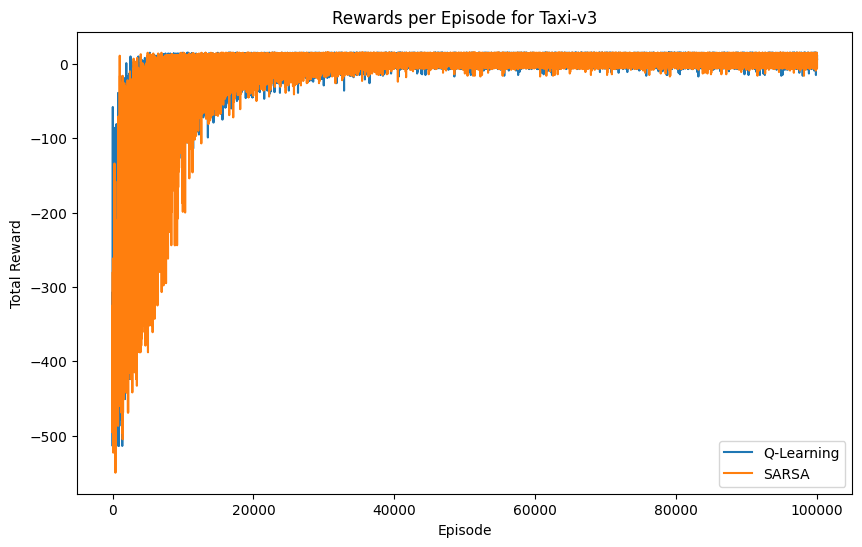

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(qlearning_rewards, label="Q-Learning")
plt.plot(sarsa_rewards, label="SARSA")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Rewards per Episode for Taxi-v3")
plt.legend()
plt.show()

Which of these algorithms are better for each environment? Why? (Also It is possible that some algorithms struggle with convergence in some of the environments. Describe why that happens.)

**Answer :**
Q-Learning is generally better for deterministic environments like the non-slippery FrozenLake because it is an off-policy algorithm that learns the optimal policy independently of the agent's actions. However, it may struggle in stochastic environments due to its off-policy nature, as it assumes the environment is deterministic. SARSA, on the other hand, is better suited for stochastic environments like the slippery FrozenLake because it is an on-policy algorithm that learns the value function based on the agent's actions, making it more robust to stochastic transitions. Monte Carlo methods excel in environments with sparse rewards, such as Taxi-v3, because they learn from complete episodes and are robust to delayed rewards. However, Monte Carlo can struggle in environments with large state spaces or high variance in rewards due to its episodic nature, which requires complete episodes for updates and can lead to slower convergence.

Explain what happens if we use the standard 8x8 FrozenLake grid instead of the custom one? Note that the standard environment has a reward +1 for reaching the goal state and rewards of 0 for going to any state other than the goal state.

**Answer :**
If we use the standard 8x8 FrozenLake-v1 environment, which provides a reward of +1 for reaching the goal and 0 for all other states, the sparse reward structure makes learning more challenging for all algorithms. Q-Learning and SARSA may struggle because they receive no feedback until the goal is reached, leading to slower convergence and less effective exploration. Monte Carlo methods, while better suited for sparse rewards, will still face challenges due to the lack of intermediate feedback, resulting in slower learning. The custom FrozenLakeEnv improves learning by providing more feedback: a reward of -1 for falling into a hole, +10 for reaching the goal, and no penalty for each step. This reward structure helps the agent learn more effectively by providing clearer signals about the consequences of its actions, leading to faster convergence compared to the standard environment.